In [1]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_dir = "/content/drive/MyDrive/Master_DS/Deep Learning/Hand Gestures Categorization/Images_dataset/augmented_all"

In [4]:
def load_images_and_labels(image_dir):
    image_data = []
    labels = []

    for image in os.listdir(image_dir):
        file_path = os.path.join(image_dir, image)
        if image.endswith(".png") or image.endswith(".jpg"):
            img = cv2.imread(file_path)
            if img is not None:
                image_data.append(img)
                label = image.split("_")[0].lower()
                labels.append(label)
            else:
                print(f"Failed to load image : {image}")
    return np.array(image_data), labels

def one_hot_encode_labels(labels):
    lb = LabelBinarizer()
    one_hot_labels = lb.fit_transform(labels)
    return one_hot_labels, lb.classes_

In [5]:
images, labels = load_images_and_labels(image_dir)

In [6]:
print(labels[1240:1260])

['spock', 'spock', 'spock', 'spock', 'spock', 'surfer', 'surfer', 'spock', 'spock', 'spock', 'spock', 'spock', 'surfer', 'surfer', 'spock', 'surfer', 'spock', 'surfer', 'spock', 'surfer']


In [7]:
one_hot_labels, class_names = one_hot_encode_labels(labels)

In [8]:
print(one_hot_labels[1240:1260])

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


In [9]:
print(class_names)

['crossed' 'fine' 'finger' 'halt' 'little' 'peace' 'rock' 'spock' 'surfer'
 'thumb']


In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    images, one_hot_labels, test_size=0.2, random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(9984, 100, 100, 3) (2496, 100, 100, 3) (9984, 10) (2496, 10)


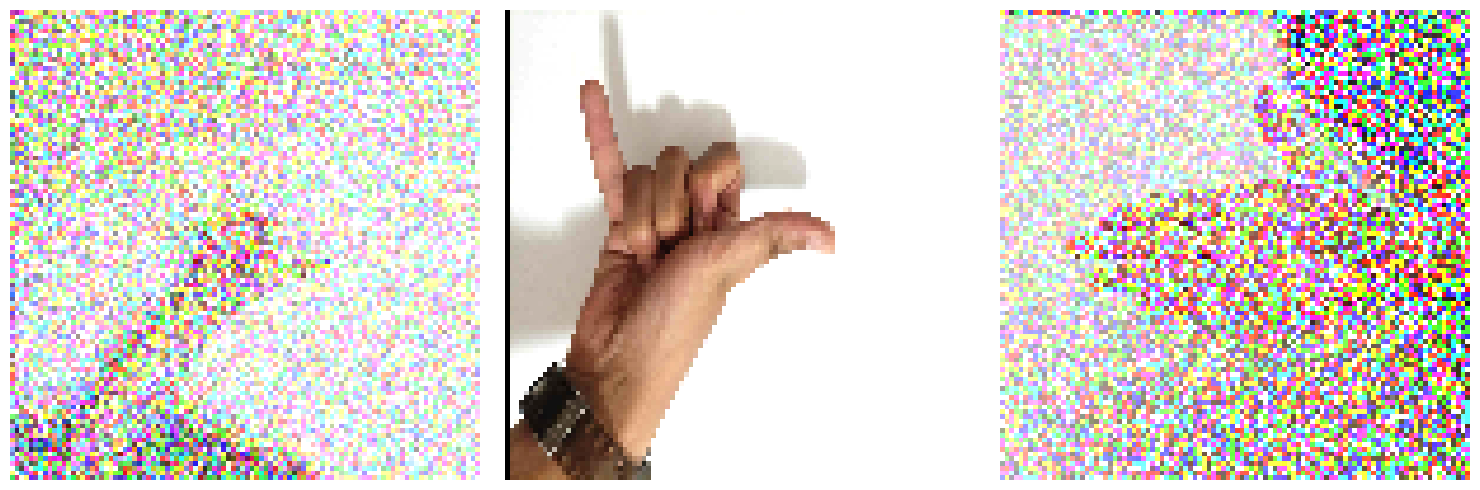

In [11]:
import matplotlib.pyplot as plt

def show_images(images, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Show 3 images from X_train
show_images(X_train)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float().to(device) / 255.0
X_val = torch.from_numpy(X_val).permute(0, 3, 1, 2).float().to(device) / 255.0
y_train = torch.from_numpy(y_train).float().to(device)
y_val = torch.from_numpy(y_val).float().to(device)

In [15]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
# Initialize the model
num_classes = y_train.shape[1]
model = ConvNet(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, predicted = torch.max(val_outputs, 1)
        _, true_labels = torch.max(y_val, 1)
        accuracy = (predicted == true_labels).float().mean()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}')

print("Training completed!")

Epoch [1/10], Loss: 2.3002, Val Loss: 2.3026, Val Accuracy: 0.1026
Epoch [2/10], Loss: 2.3036, Val Loss: 2.3026, Val Accuracy: 0.1022
Epoch [3/10], Loss: 2.2712, Val Loss: 2.2978, Val Accuracy: 0.1126
Epoch [4/10], Loss: 1.7022, Val Loss: 1.9447, Val Accuracy: 0.3438
Epoch [5/10], Loss: 1.3075, Val Loss: 1.3929, Val Accuracy: 0.5513
Epoch [6/10], Loss: 0.9845, Val Loss: 1.0006, Val Accuracy: 0.6931
Epoch [7/10], Loss: 0.7407, Val Loss: 0.8511, Val Accuracy: 0.7420
Epoch [8/10], Loss: 0.6183, Val Loss: 0.7744, Val Accuracy: 0.7596
Epoch [9/10], Loss: 0.6139, Val Loss: 0.6698, Val Accuracy: 0.7829
Epoch [10/10], Loss: 0.5522, Val Loss: 0.6565, Val Accuracy: 0.7945
Training completed!


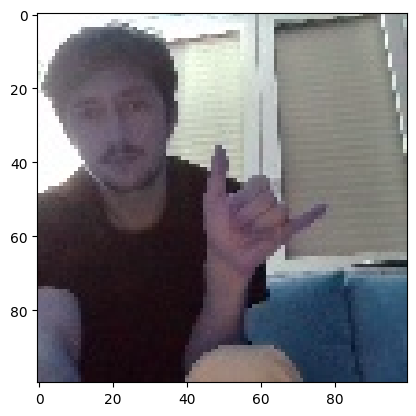

In [35]:
# Load the image
img_path = "/content/test_surfer.jpg"  # Replace with your image path
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

# Preprocess the image
img = cv2.resize(img, (100, 100)) #Resize to match training data
img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0) / 255.0
img = img.to(device)

In [36]:
# Make a prediction
model.eval()
with torch.no_grad():
    output = model(img)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
predicted_label = class_names[predicted_class]

print(f"Predicted Label: {predicted_label}")

Predicted Label: surfer


In [37]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Master_DS/Deep Learning/Hand Gestures Categorization/model_E10.pth')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Initialize the model
num_classes = y_train.shape[1]
model2 = ConvNet(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    model2.train()
    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model2(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model2.eval()
    with torch.no_grad():
        val_outputs = model2(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, predicted = torch.max(val_outputs, 1)
        _, true_labels = torch.max(y_val, 1)
        accuracy = (predicted == true_labels).float().mean()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}')

print("Training completed!")

Epoch [1/20], Loss: 2.2963, Val Loss: 2.3202, Val Accuracy: 0.1018
Epoch [2/20], Loss: 2.3065, Val Loss: 2.3026, Val Accuracy: 0.1030
Epoch [3/20], Loss: 2.1572, Val Loss: 2.2402, Val Accuracy: 0.1679
Epoch [4/20], Loss: 1.7058, Val Loss: 1.8248, Val Accuracy: 0.4107
Epoch [5/20], Loss: 1.2529, Val Loss: 1.2832, Val Accuracy: 0.5905
Epoch [6/20], Loss: 0.7711, Val Loss: 0.9699, Val Accuracy: 0.7015
Epoch [7/20], Loss: 0.6370, Val Loss: 0.8405, Val Accuracy: 0.7292
Epoch [8/20], Loss: 0.4631, Val Loss: 0.7401, Val Accuracy: 0.7588
Epoch [9/20], Loss: 0.3998, Val Loss: 0.6686, Val Accuracy: 0.7780
Epoch [10/20], Loss: 0.4739, Val Loss: 0.6288, Val Accuracy: 0.8009
Epoch [11/20], Loss: 0.2312, Val Loss: 0.5682, Val Accuracy: 0.8141
Epoch [12/20], Loss: 0.1942, Val Loss: 0.5733, Val Accuracy: 0.8201
Epoch [13/20], Loss: 0.1425, Val Loss: 0.5920, Val Accuracy: 0.8201
Epoch [14/20], Loss: 0.1061, Val Loss: 0.5995, Val Accuracy: 0.8225
Epoch [15/20], Loss: 0.2141, Val Loss: 0.5945, Val Accura

In [ ]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/Master_DS/Deep Learning/Hand Gestures Categorization/model_E20.pth')
print("Model saved successfully!")

Model saved successfully!
